In [1]:
1+1

2

In [2]:
import numpy as np
import pylab as plt

import sys
sys.path.append('/data/id01/inhouse/bellec/software/sharedipynb/gitlab/bcdi_eb/')
from Plot_utilities import *
from Object_utilities import *
from Global_utilities import *

from Features import *

my_cmap = MIR_Colormap()

In [3]:
import vedo

# Function

In [3]:
@gif.frame
def Gif_one_slice_plot(module_ortho, phase_ortho, strain,#d_spacing,
                          tilt_comp1, tilt_comp2,
                       index,
                 voxel_sizes=None,
                 threshold=.1, factor=.2,
                       vmin_list=None,vmax_list=None,
                 fw=2.7,
                 return_figure=False,
                       verbose=True):
    
    if verbose:
        print(max(module_ortho.shape)-index, end=' ')
    
    fig,ax = plt.subplots(3,5,figsize=(fw*5, fw*3))

    xlabel = ['Z (nm)', 'Z (nm)', 'Y (nm)']
    ylabel = ['Y', 'X', 'X']
    
    if vmin_list is None:
        vmin_list = [None for n in range(5)]
    if vmax_list is None:
        vmax_list = [None for n in range(5)]

    plot_2D_slices_middle_one_array3D(module_ortho, index=index,
                                      cmap='gray_r', voxel_sizes=voxel_sizes, add_colorbar=True,
                                      vmin=vmin_list[0], vmax=vmax_list[0],
                                      xlabel=xlabel, ylabel=ylabel,
                                      fig=fig,ax=ax[:,0])

    plot_2D_slices_middle_one_array3D(phase_ortho, index=index,
                                      cmap='hsv', voxel_sizes=voxel_sizes, add_colorbar=True,
                                      vmin=vmin_list[1], vmax=vmax_list[1],
                                      fig=fig,ax=ax[:,1])

    plot_2D_slices_middle_one_array3D(1e2*strain, index=index,
                                      cmap='coolwarm', voxel_sizes=voxel_sizes, add_colorbar=True,
                                      vmin=vmin_list[2], vmax=vmax_list[2],
                                      fig=fig,ax=ax[:,2])
    
    plot_2D_slices_middle_one_array3D(tilt_comp1, index=index,
                                      cmap='coolwarm', voxel_sizes=voxel_sizes, add_colorbar=True,
                                      vmin=vmin_list[3], vmax=vmax_list[3],
                                      fig=fig,ax=ax[:,3])
    
    plot_2D_slices_middle_one_array3D(tilt_comp2, index=index,
                                      cmap='coolwarm', voxel_sizes=voxel_sizes, add_colorbar=True,
                                      vmin=vmin_list[4], vmax=vmax_list[4],
                                      fig=fig,ax=ax[:,4])
    

    ax[0,0].set_title('module', fontsize=20*fw/3)
    ax[0,1].set_title('phase', fontsize=20*fw/3)
    ax[0,2].set_title('strain (%)', fontsize=20*fw/3)
    ax[0,3].set_title('tilt along X', fontsize=20*fw/3)
    ax[0,4].set_title('tilt along Y', fontsize=20*fw/3)
    
    for axe in ax.flatten():
        axe.tick_params(axis='both', which='major', labelsize=15*fw/4)
        axe.xaxis.get_label().set_fontsize(20*fw/3)
        axe.yaxis.get_label().set_fontsize(20*fw/3)
        
    fig.suptitle('Bragg wavevector along Z', fontsize=15)

    fig.tight_layout()
    
    if return_figure:
        return fig,ax
    else:
        return

In [4]:
def make_gif_module_phase_strain_tilt(module_ortho, phase_ortho, strain,
                          tilt_comp1, tilt_comp2,
            voxel_sizes=None,
            vmin_phase=None,vmax_phase=None,
            vmax_strain=None,
            fw=4, name='gif_default_name', duration=10):
    
    vmin_list = [np.nanmin(module_ortho),
                 np.nanmin(phase_ortho),
                 1e2*np.nanmin(strain),
                 np.nanmin(tilt_comp1),
                 np.nanmin(tilt_comp2)]
    vmax_list = [np.nanmax(module_ortho),
                 np.nanmax(phase_ortho),
                 1e2*np.nanmax(strain),
                 np.nanmax(tilt_comp1),
                 np.nanmax(tilt_comp2)]
    
    frames = [Gif_one_slice_plot(module_ortho, phase_ortho, strain,
                          tilt_comp1, tilt_comp2,
                       index,
                 voxel_sizes=voxel_sizes,
                 vmin_list=vmin_list,vmax_list=vmax_list)
              for index in range(max(module_ortho.shape))]
    gif.save(frames, name+'.gif', duration=duration, unit='s', between='startend')
    print('gif saved in : ',name+'.gif')
    return

## gif Bragg planes

In [5]:
def schematic_Bragg_planes_figure(displacement, qcen, voxel_sizes,
                                  strain=None,
                                  module_ortho=None,
                                  axis=0, slice_index=None,
                                  visual_factor=50,
                                  dislo_threshold = None,
                                  close_roi=False,
                                  fig=None, ax=None, fw=6, fig_title=None):
    angle_bragg_last_axis = np.rad2deg(np.arccos(np.dot(qcen, [0,0,1])/ np.linalg.norm(qcen)))
    if angle_bragg_last_axis > 1.:
        raise ValueError('qcen is not along the last axis ! My function is not ready for that.')
        return
    
    if axis==2 :
        raise ValueError('axis should be 0 or 1!')
    
    if slice_index is None:
        s = slice_middle_array_along_axis(displacement, axis=axis)
    else:
        s = [slice(None, None, None) for ii in range(displacement.ndim)]
        s[axis] = min(slice_index, displacement.shape[axis]-1)#slice_index
        s = tuple(s)
        
    if fig is None:
        fig,ax = plt.subplots(1,1, figsize=(fw,fw))
        
    if strain is not None:
#         strain_color_slice = np.copy(strain[s])
#         strain_color_slice = strain_color_slice - np.nanmin(strain_color_slice)
#         strain_color_slice = strain_color_slice/ np.nanmax(strain_color_slice)
        
        strain_color = np.copy(strain)
        strain_color -= np.nanmin(strain_color)
        strain_color = strain_color/np.nanmax(strain_color)
        strain_color_slice = np.copy(strain_color[s])
    
    displacement_slice = displacement[s]
    voxel_sizes_slice = np.delete(voxel_sizes,axis)

    # Create a regular grid
    pos = np.indices(displacement_slice.shape)
    pos[0] = pos[0]*voxel_sizes_slice[0]*.1
    pos[1] = pos[1]*voxel_sizes_slice[1]*.1

    pos = pos + .1*displacement_slice[None] * np.array([0,1])[:,None,None] * visual_factor

    for n in range(displacement_slice.shape[1]):
        # Just a quick test
        if dislo_threshold is not None:
            grad_amp = np.abs(np.gradient(pos[1,:,n]))
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                indices = grad_amp>np.nanmedian(grad_amp)*20
            pos[:,indices,n] = np.nan
        ax.plot(pos[1,:,n], pos[0,:,n], 'k-', linewidth=1, markersize=1, alpha=1)
        
        if strain is not None:
            strain_line = strain_color_slice[:,n]
            color = cm.coolwarm(strain_line)
#             color = cm.jet(strain_line)
            sc = ax.scatter(pos[1,:,n], pos[0,:,n], s=20*fw/10., color=color, alpha=1)        
    
    ax.set_xlabel('nm', fontsize=15*fw/4.)
        
    if strain is not None:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        norm = mpl.colors.Normalize(vmin=np.nanmin(1e2*strain), vmax=np.nanmax(1e2*strain))
        cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='coolwarm'),
                     cax=cax, orientation='vertical')#, label='Strain (%)')
        cbar.set_label('strain (%)', size=20*fw/6)
    
    if not close_roi :
        ax.set_xlim(0, displacement_slice.shape[1]*voxel_sizes_slice[1]*.1)
        ax.set_ylim(0, displacement_slice.shape[0]*voxel_sizes_slice[0]*.1)
    
    ax.invert_yaxis()

    if fig_title is None:
        fig_title = 'Schematic Bragg\nplanes distortion'
    ax.set_title(fig_title, fontsize=12*fw/4.)
    ax.set_aspect('equal', 'box')
    
    return

In [6]:
@gif.frame
def Gif_one_slice_schematic_Bragg_planes(displacement, qcen, voxel_sizes, slice_index,
                                  strain=None,
                                  visual_factor=200, dislo_threshold=None,
                                  close_roi=True, fw=7):
    fig,ax = plt.subplots(1,2, figsize=(2*fw,fw))
    

    for n, axis in enumerate([0,1]):
        schematic_Bragg_planes_figure(displacement, qcen, voxel_sizes,
                                          strain=strain,
                                          axis=axis, slice_index=slice_index,
                                          visual_factor=visual_factor,
                                      dislo_threshold=dislo_threshold,
                                          close_roi=False,
                                          fig=fig, ax=ax[n], fig_title=f'slice along axis {axis}')
        
    fig.suptitle('Schematic Bragg planes', fontsize=20*fw/6.)
    fig.tight_layout()

In [7]:
def make_gif_schematic_Bragg_planes(displacement, qcen, voxel_sizes,
                                    strain=None,
                                    visual_factor=200, dislo_threshold=None,
                                    fw=7,
                                    name='gif_default_name', duration=10):
    
    
    frames = [Gif_one_slice_schematic_Bragg_planes(displacement, qcen, voxel_sizes, slice_index,
                                  strain=strain,
                                  visual_factor=visual_factor, dislo_threshold=dislo_threshold,
                                  close_roi=False, fw=fw)
              for slice_index in range(max(displacement.shape[:2]))]
    gif.save(frames, name+'.gif', duration=duration, unit='s', between='startend')
    print('gif saved in : ',name+'.gif')
    return

# Load final object

In [8]:
# filename = 'Reconstructions_CropAlgo/B18S2P1_h5file_B18S2P1_0007_scan29_crop/final_obj/final_object.npz'
filename = 'Reconstructions_CropAlgo/CA_holder4_homo_h5file_CA_holder4_homo_BCDI_0005_scan30_average_scans_3_6_9_12_15_18_21_24_27_30/final_obj/final_object.npz'
# filename = 'Reconstructions_CropAlgo/CA_holder5_hetero_new_hope_h5file_CA_holder5_hetero_new_hope_BCDI_0060_scan6_rebin_2_1_1_background1/final_obj/final_object.npz'
file = np.load(filename)

voxel_sizes = file['voxel_sizes']

module_ortho = file['module_ortho']
phase_ortho = file['phase_ortho']
# strain_hetero = file['strain_hetero']
displacement = file['displacement']
strain = file['strain']
qcen = file['qcen']

tilt_comp1 = file['tilt_comp1']
tilt_comp2 = file['tilt_comp2']

displacement = file['displacement']

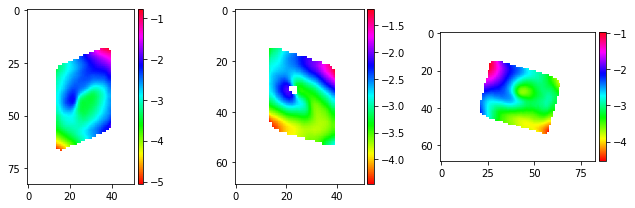

In [9]:
plot_2D_slices_middle_one_array3D(phase_ortho, cmap='hsv')

# Crop the array to remove blank part of the figure

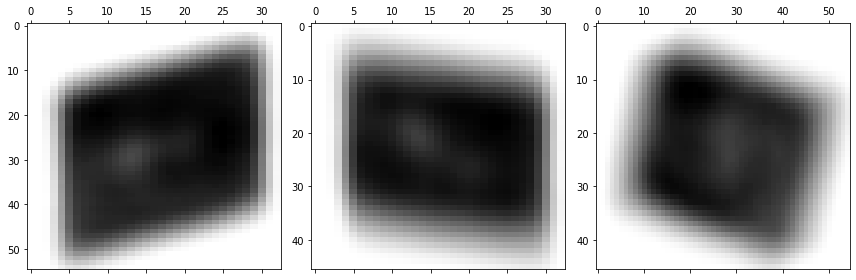

In [10]:
roi = automatic_object_roi(module_ortho,factor=.1)
plot_3D_projections(module_ortho[roi[0]:roi[1],roi[2]:roi[3],roi[4]:roi[5]], cmap='gray_r',log_scale=False)

In [11]:
module_ortho = apply_roi(module_ortho, roi)
phase_ortho = apply_roi(phase_ortho, roi)
strain = apply_roi(strain, roi)
tilt_comp1 = apply_roi(tilt_comp1, roi)
tilt_comp2 = apply_roi(tilt_comp2, roi)
displacement = apply_roi(displacement, roi)

# Create a path for the gifs

In [12]:
path_save = 'saved_gifs/'
check_path_create(path_save)

# Make a gif of final figure

In [13]:
savename = f'{path_save}{filename.split("/")[-3]}_module_phase_strain_tilt'
print(savename)

saved_gifs/CA_holder4_homo_h5file_CA_holder4_homo_BCDI_0005_scan30_average_scans_3_6_9_12_15_18_21_24_27_30_module_phase_strain_tilt


In [15]:
fw = 4
axis=0

make_gif_module_phase_strain_tilt(module_ortho, phase_ortho, strain,
                          tilt_comp1, tilt_comp2,
            voxel_sizes=voxel_sizes,
            vmin_phase=None,vmax_phase=None,
            vmax_strain=None,
            fw=4, name=savename, duration=10)

55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 gif saved in :  saved_gifs/CA_holder4_homo_h5file_CA_holder4_homo_BCDI_0005_scan30_average_scans_3_6_9_12_15_18_21_24_27_30_module_phase_strain_tilt.gif


# Gif schematic Bragg planes

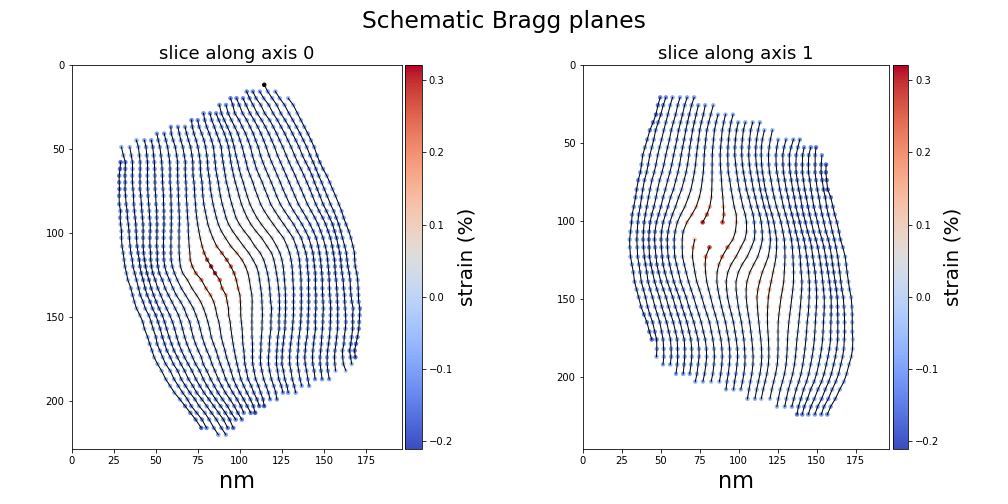

In [25]:
visual_factor = 300
Gif_one_slice_schematic_Bragg_planes(displacement, qcen, voxel_sizes, None,
                                  strain=strain,
                                  visual_factor=visual_factor, dislo_threshold=None,
                                  close_roi=False)

In [26]:
savename = f'{path_save}{filename.split("/")[-3]}_schematic_Bragg_planes'
print(savename)

saved_gifs/CA_holder4_homo_h5file_CA_holder4_homo_BCDI_0005_scan30_average_scans_3_6_9_12_15_18_21_24_27_30_schematic_Bragg_planes


In [27]:
make_gif_schematic_Bragg_planes(displacement, qcen, voxel_sizes,
                                    strain=strain,
                                    visual_factor=visual_factor, dislo_threshold=None,
                                    name=savename, duration=10)

gif saved in :  saved_gifs/CA_holder4_homo_h5file_CA_holder4_homo_BCDI_0005_scan30_average_scans_3_6_9_12_15_18_21_24_27_30_schematic_Bragg_planes.gif


# Make a gif of a 3D rotating module

In [16]:
# # Rescale the object module
# module_ortho = module_ortho/np.max(module_ortho)

# iso_val=0.25
# test = np.copy(module_ortho)
# test[test<iso_val] = 0.

# plot_3D_projections(test)

In [17]:
# make_gif_pixels_3d(module_ortho,
#                        iso_val=iso_val,
#                        name='{}{}_rotating_module'.format(path_save, filename.split('/')[-3]),
#                    duration=10, nb_angles=30)

# Paraview gif

In [ ]:
path = 'Paraview_gif/temporary_png/'
files = sorted(os.listdir(path))
files = [path+f for  f in files]

In [ ]:
make_gif_list_images(files, name='Paraview_gif/dataset69_scan3', duration=10,
                      fw=6)

# gif list of images

In [18]:
path = 'Temp_saved_Bragg_third_example_schematic_axis1/'
files = sorted(os.listdir(path))
files = [path+f for  f in files]

FileNotFoundError: [Errno 2] No such file or directory: 'Temp_saved_Bragg_third_example_schematic_axis1/'

In [ ]:
make_gif_list_images(files, name='schematic_bragg_planes_3rddexample_axis1', duration=10,
                      fw=6)

# Dev Schematic Bragg planes

In [9]:
from matplotlib import cm
def schematic_Bragg_planes_figure(displacement, qcen, voxel_sizes,
                                  strain=None,
                                  module_ortho=None,
                                  axis=0, slice_index=None,
                                  visual_factor=50,
                                  close_roi=False,
                                  fig=None, ax=None, fw=6):
    angle_bragg_last_axis = np.rad2deg(np.arccos(np.dot(qcen, [0,0,1])/ np.linalg.norm(qcen)))
    if angle_bragg_last_axis > 1.:
        raise ValueError('qcen is not along the last axis ! My function is not ready for that.')
        return
    
    if axis==2 :
        raise ValueError('axis should be 0 or 1!')
    
    if slice_index is None:
        s = slice_middle_array_along_axis(displacement, axis=axis)
    else:
        s = [slice(None, None, None) for ii in range(displacement.ndim)]
        s[axis] = slice_index
        s = tuple(s)
        
    if fig is None:
        fig,ax = plt.subplots(1,1, figsize=(fw,fw))
        
    if strain is not None:
        strain_color = strain-np.nanmin(strain)
        strain_color = strain_color/np.nanmax(strain_color)
        strain_color_slice = strain_color[s]
    
    displacement_slice = displacement[s]
    voxel_sizes_slice = np.delete(voxel_sizes,axis)

    # Create a regular grid
    pos = np.indices(displacement_slice.shape)
    pos[0] = pos[0]*voxel_sizes_slice[0]*.1
    pos[1] = pos[1]*voxel_sizes_slice[1]*.1

    pos = pos + .1*displacement_slice[None] * np.array([0,1])[:,None,None] * visual_factor

#     mean = np.nanmean(pos[0])
#     pos[0] = -(pos[0]-mean) + mean 
    for n in range(displacement_slice.shape[1]):
        x = pos[1,:,n]
        y = pos[0,:,n]
        if strain is not None :
            strain_line = strain_color_slice[:,n]
            color = cm.jet(strain_line)
        else:
            color=['k' for ii in range(len(x))]
        for i in np.arange(len(x)-1):
            ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=color[i], linewidth=3*fw/10)
#         ax.plot(pos[1,:,n], pos[0,:,n], 'k-', linewidth=1, markersize=1, alpha=.3)

        
        if strain is not None:
            strain_line = strain_color_slice[:,n]
            color = cm.coolwarm(strain_line)
#             color = cm.bwr(strain_line)
        else:
            color = 'k'
#         ax.scatter(pos[1,:,n], pos[0,:,n], s=60*fw/10., color=color)
        
    ax.set_xlabel('nm', fontsize=15*fw/4.)
    
    if not close_roi :
        ax.set_xlim(0, displacement_slice.shape[1]*voxel_sizes_slice[1]*.1)
        ax.set_ylim(0, displacement_slice.shape[0]*voxel_sizes_slice[0]*.1)
#     else:
#         ax.set_xlim(np.nanmin(pos[1]), np.nanmax(pos[1]))
#         ax.set_ylim(np.nanmin(pos[0]), np.nanmax(pos[0]))
    
        
    ax.invert_yaxis()

    ax.set_title('Schematic Bragg\nplanes distortion', fontsize=12*fw/4.)
    ax.set_aspect('equal', 'box')
    
    return

In [10]:
def final_figure_schematic_Bragg_planes(displacement, module_ortho, strain,
                                        qcen, voxel_sizes,
                                       threshold=0.1, factor=0.2,
                                       visual_factor = 500,
                                       fw = 10):
    roi = automatic_object_roi(module_ortho, threshold=threshold, factor=factor)
    module_ortho_roi = apply_roi(module_ortho, roi)
    
    fig,ax = plt.subplots(1,2, figsize=(fw*2,fw))
    
    extent = [[0,module_ortho_roi.shape[2]*voxel_sizes[2]*.1, module_ortho_roi.shape[1]*voxel_sizes[1]*.1, 0],
              [0,module_ortho_roi.shape[2]*voxel_sizes[2]*.1, module_ortho_roi.shape[0]*voxel_sizes[0]*.1, 0]]
    for axis in [0,1]:
        module_ortho_slice = module_ortho_roi[slice_middle_array_along_axis(module_ortho_roi,axis=axis)]
        ax[axis].matshow(module_ortho_slice, cmap='gray_r', extent=extent[axis], alpha=.5)
        
        schematic_Bragg_planes_figure(apply_roi(displacement, roi), qcen, voxel_sizes,
                                      strain = apply_roi(strain,roi),
                                          axis=axis,
                                          visual_factor=visual_factor,
                                          fig=fig, ax=ax[axis])
        ax[axis].set_xlabel('nm',fontsize=12*fw/4.)
        ax[axis].xaxis.set_ticks_position('bottom')
        ax[axis].xaxis.set_tick_params(labelsize=8*fw/4.)
        ax[axis].yaxis.set_tick_params(labelsize=8*fw/4.)
        ax[axis].set_title(f'slice along axis {axis}',fontsize=12*fw/4.)
        

    fig.tight_layout()
        
    return

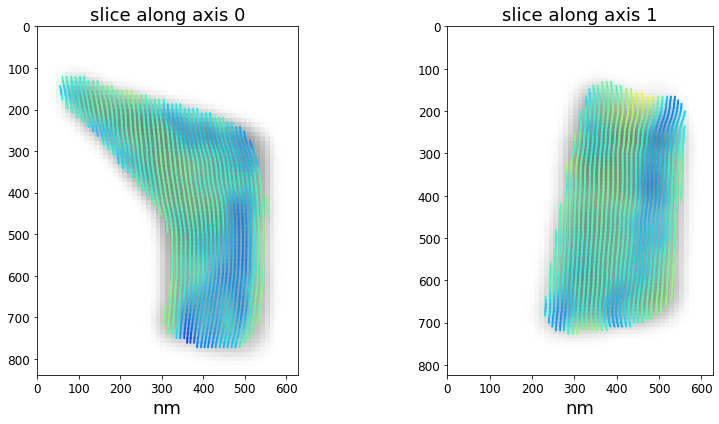

In [11]:
visual_factor = 500
final_figure_schematic_Bragg_planes(displacement, module_ortho, strain,
                                        qcen, voxel_sizes,
                                       threshold=0.1, factor=0.15,
                                       visual_factor = visual_factor, fw=6)

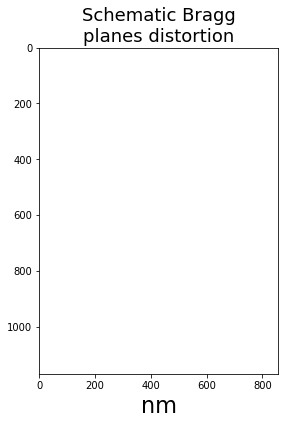

In [12]:
visual_factor = 200

schematic_Bragg_planes_figure(displacement, qcen, voxel_sizes,
                              strain,
                                  axis=0, slice_index=20,
                                  visual_factor=visual_factor)

In [13]:
@gif.frame
def gif_schematic_Bragg_planes(displacement, module_ortho, strain,
                                        qcen, voxel_sizes,
                               axis=0, slice_index=None,
                                       visual_factor = 500,
                                       fig=None, ax=None, fw = 10,
                              verbose=False):
#     roi = automatic_object_roi(module_ortho, threshold=threshold, factor=factor)
#     module_ortho_roi = apply_roi(module_ortho, roi)

    if verbose and slice_index is not None:
        print(module_ortho.shape[axis]-slice_index, end=' ')
    
    if fig is None:
        fig,ax = plt.subplots(1,1, figsize=(fw,fw))
    else:
        fig.clf()
    
    extent = [[0,module_ortho.shape[2]*voxel_sizes[2]*.1, module_ortho.shape[1]*voxel_sizes[1]*.1, 0],
              [0,module_ortho.shape[2]*voxel_sizes[2]*.1, module_ortho.shape[0]*voxel_sizes[0]*.1, 0]]
    
    s = [slice(None, None, None) for ii in range(module_ortho.ndim)]
    s[axis] = slice_index
    s = tuple(s)
    
    module_ortho_slice = module_ortho[s]
#     ax.matshow(module_ortho_slice, cmap='gray_r', extent=extent[axis], alpha=.5,
#                vmin=np.nanmin(module_ortho_slice), vmax=np.nanmax(module_ortho_slice))
        
    schematic_Bragg_planes_figure(displacement, qcen, voxel_sizes,
                                  #strain=strain,
                                      axis=axis, slice_index=slice_index,
                                      visual_factor=visual_factor,
                                      fig=fig, ax=ax)
    ax.set_xlabel('nm',fontsize=12*fw/4.)
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_tick_params(labelsize=8*fw/4.)
    ax.yaxis.set_tick_params(labelsize=8*fw/4.)
    ax.set_title(f'slice along axis {axis}. slice_index {slice_index}',fontsize=12*fw/4.)  

    fig.tight_layout()
        
    return

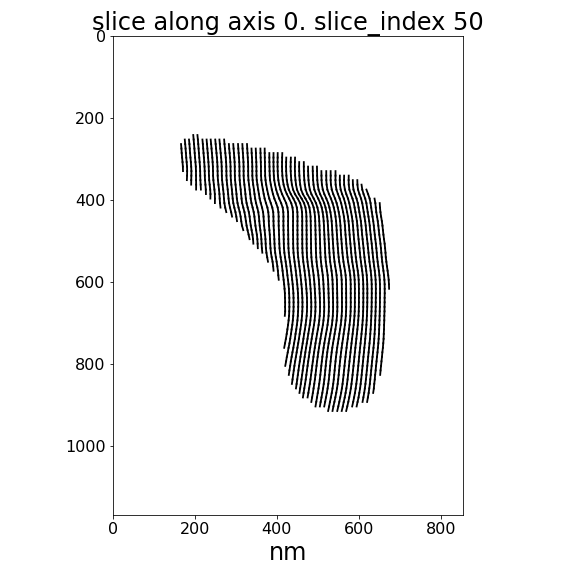

In [14]:
gif_schematic_Bragg_planes(displacement, module_ortho, strain,
                                        qcen, voxel_sizes,
                               axis=0, slice_index=50,
                                       visual_factor = 300,
                                       fw = 8)

In [15]:
def make_gif_schematic_Bragg_planes(displacement, module_ortho, strain, 
                                    qcen, voxel_sizes,
                                    threshold=0.1, factor=0.2, 
                                    visual_factor = 200,
                                    axis=0,
                                    name='gif_default_name', duration=20, fw=8):
                                    
    roi = automatic_object_roi(module_ortho, threshold=threshold, factor=factor)
    displacement_roi = apply_roi(displacement, roi)
    module_ortho_roi = apply_roi(module_ortho, roi)
    strain_roi = apply_roi(strain, roi)
    
    frames = [gif_schematic_Bragg_planes(displacement_roi, module_ortho_roi, strain_roi,
                                        qcen, voxel_sizes,
                               axis=axis, slice_index=slice_index,
                                       visual_factor = visual_factor,
                                       fw = fw, verbose=True) for slice_index in range(module_ortho_roi.shape[axis])]
    gif.save(frames, name+'.gif', duration=duration, unit='s', between='startend')
    print('gif saved in : ',name+'.gif')
    return

In [16]:
visual_factor = 500

In [17]:
axis = 0
make_gif_schematic_Bragg_planes(displacement, module_ortho, strain, 
                                    qcen, voxel_sizes,
                                    threshold=0.1, factor=0.2, 
                                    visual_factor = visual_factor,
                                    axis=axis,
                                    name=f'test4_gif_Bragg_planes_axis{axis}', duration=20, fw=8)

102 101 100 99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 gif saved in :  test4_gif_Bragg_planes_axis0.gif


In [41]:
# axis = 1
# make_gif_schematic_Bragg_planes(displacement, module_ortho, strain, 
#                                     qcen, voxel_sizes,
#                                     threshold=0.1, factor=0.2, 
#                                     visual_factor = visual_factor,
#                                     axis=axis,
#                                     name=f'test4_gif_Bragg_planes_axis{axis}', duration=20, fw=8)

82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 gif saved in :  test2_gif_Bragg_planes_axis1.gif


# Dev vedo

In [3]:
from paraview.simple import *

ModuleNotFoundError: No module named 'paraview'

In [1]:
import vedo
from vedo import Volume, Plotter, printc, show, screenshot, Axes, settings, Light, Point
import colorcet
import numpy as np
import sys
from PIL import Image, ImageDraw, ImageFont
import os
import tqdm
from vedo import settings
settings.screenshot_transparent_background = False
settings.default_backend = "vtk"

In [2]:
filename = 'Reconstructions_CropAlgo/Pd_GC_0002_scan64/final_obj/Pd_GC_0002_scan64.vti'
scan = 2
angle = 210
# fn_vti = f'cdiutils_S{scan}_structural_properties.vti'
iso = 0.5
nbimage = 60
# path_exp = f''
# path_results = f''
phaselim, strainlim = np.pi/10, 2e-2

In [3]:
# path = '/Users/marieingridrichard/mount/carine/Experiment2024/hc4050_Jan24/results/Pd_GC_0001/S2/'
# scan = 2
# angle = 210
# fn_vti = f'cdiutils_S{scan}_structural_properties.vti'
# iso = 0.5
# nbimage = 60
# path_exp = f''
# path_results = f''
# phaselim, strainlim = np.pi/10, 2e-2

In [4]:
vol = Volume(filename)
# vol = Volume(path + fn_vti)
### If one wants to check what's in the .vti
printc('Arrays in Volume are:\n', vol.pointdata.keys(), invert=True)
vol.pointdata.select("amplitude")  # select the first data array as the active one

## Some parameters of interest
cx, cy, cz = vol.center() # center of the cell
nx, ny, nz = vol.dimensions() # number of voxels
dx, dy, dz = vol.spacing()
sx, sy, sz = nx*dx, ny*dy, nz*dz # size of the cell

Arrays in Volume are:
 ['module_ortho', 'phase_ortho', 'strain', 'strain_paraview', 'tilt_comp1_paraview', 'tilt_comp2_paraview']


In [5]:
data, value = 'strain', 'strain'
vmin, vmax, cmap = -strainlim, strainlim, 'coolwarm'

In [6]:
isosurface = vol.isosurface(iso).cmap(cmap, value, vmin = vmin, vmax = vmax)

[vedo.pointcloud.py:2832] ERROR: in cmap(), cannot find points array strain ...skip coloring.


In [7]:
# ## Specular parameters
# ambient, diffuse, specular = 0, 1, 0.4 # paraview values
# specularPower, specularColor= 100, 'white' # paraview values
# isosurface.lighting('metallic', ambient, diffuse, specular, specularPower, specularColor)

In [ ]:
for angle in tqdm.tqdm(range(0, 360, 360//nbimage)):
    s = np.sin(np.deg2rad(angle))
    c = np.cos(np.deg2rad(angle))   
    
    cam_rot = {'pos': [cx+s*sx*2.5, cy+0.425*sy*2, cz+c*sz*2.5],
                'viewup': [0, 1, 0],
                'focalPoint': [cx, cy, cz]}       

    ## Lights
    p1 = Point([cx+s*sx*2, cy+0.425*sy*2, cz+c*sz*2], c='red')
    p2 = Point([cx+c*sx*2, cy+0.425*sy*2, cz-s*sz*2], c='green')
    p3 = Point([cx-s*sx*2, cy+0.425*sy*2, cz-c*sz*2], c='blue')
    l1 = Light(p1, c='white', intensity=1)
    l2 = Light(p2, c='white', intensity=0.2)
    l3 = Light(p3, c='white', intensity=0.2)

    img_fn = f'NP_Pt_{data}_cam_{angle}.png'
    vp = Plotter(offscreen=True) # change to False for interaction
    vp.show((isosurface, ""), 
            l1, l2, l3, 
            camera=cam_rot, 
            axes=0)
    
    screenshot(img_fn)

    vp.close()

  0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
isosurface = vol.isosurface(iso).cmap(cmap, value, vmin = vmin, vmax = vmax)

## Specular parameters
ambient, diffuse, specular = 0, 1, 0.4 # paraview values
specularPower, specularColor= 100, 'white' # paraview values
isosurface.lighting('metallic', ambient, diffuse, specular, specularPower, specularColor)


In [4]:
vol = Volume(filename)
# vol = Volume(path + fn_vti)
### If one wants to check what's in the .vti
printc('Arrays in Volume are:\n', vol.pointdata.keys(), invert=True)
vol.pointdata.select("amplitude")  # select the first data array as the active one

## Some parameters of interest
cx, cy, cz = vol.center() # center of the cell
nx, ny, nz = vol.dimensions() # number of voxels
dx, dy, dz = vol.spacing()
sx, sy, sz = nx*dx, ny*dy, nz*dz # size of the cell

## Phase or Strain
# data, value = 'Phase', 'phase'
# vmin, vmax, cmap = -phaselim, phaselim, 'turbo'

data, value = 'Het_Strain', 'het_strain'
vmin, vmax, cmap = -strainlim, strainlim, 'cet_CET_D13'

isosurface = vol.isosurface(iso).cmap(cmap, value, vmin = vmin, vmax = vmax)

## Specular parameters
ambient, diffuse, specular = 0, 1, 0.4 # paraview values
specularPower, specularColor= 100, 'white' # paraview values
isosurface.lighting('metallic', ambient, diffuse, specular, specularPower, specularColor)

## Plotters
for angle in tqdm.tqdm(range(0, 360, 360//nbimage)):
    s = np.sin(np.deg2rad(angle))
    c = np.cos(np.deg2rad(angle))   
    
    cam_rot = {'pos': [cx+s*sx*2.5, cy+0.425*sy*2, cz+c*sz*2.5],
                'viewup': [0, 1, 0],
                'focalPoint': [cx, cy, cz]}       

    ## Lights
    p1 = Point([cx+s*sx*2, cy+0.425*sy*2, cz+c*sz*2], c='red')
    p2 = Point([cx+c*sx*2, cy+0.425*sy*2, cz-s*sz*2], c='green')
    p3 = Point([cx-s*sx*2, cy+0.425*sy*2, cz-c*sz*2], c='blue')
    l1 = Light(p1, c='white', intensity=1)
    l2 = Light(p2, c='white', intensity=0.2)
    l3 = Light(p3, c='white', intensity=0.2)

    img_fn = f'NP_Pt_{data}_cam_{angle}.png'
    vp = Plotter(offscreen=True) # change to False for interaction
    vp.show((isosurface, ""), 
            l1, l2, l3, 
            camera=cam_rot, 
            axes=0)
    
    screenshot(img_fn)

    vp.close()

IndexError: list index out of range